### VQSD PENNYLANE

to do:
- base experiment in pennylane from original paper https://arxiv.org/pdf/1810.10506
- create state to diagonalize $\rho = $  $|+\rangle \langle +| $
- create parameterized unitary $U_p(\alpha)$

such that:
$\tilde\rho_{p}(\alpha) := U_p(\alpha) \rho U_p^{\dagger}(\alpha)$
is approximately diagonal at the optimal value of $\alpha_{opt}$

- create a layered ansatz with the form:
$U_p(\alpha) = L_1(\alpha_1)L_2(\alpha_2) ...  L_p(\alpha_p)$
    -  p is a hyperparameter that sets the number of layers $L_i(α_i)$, and each $α_i$ is a set of optimization parameters that corresponds to internal gate angles within the layer.
    
- define the cost function: $C(U_p(\alpha) = qC_1(U_P(\alpha)) + (1- q) C_2(U_p(\alpha))$, where:
     - $C_1(U_p(\alpha)) = Tr(\rho^2) - Tr(Z(\tilde \rho)^2)$
     - $C_2(U_p(\alpha)) = Tr(\rho^2) - \dfrac{1}n \sum^{n}_{j=1}Z_j(\tilde \rho)^2 $
         - $Z$ and $Z_j$ are quantum channels that dephase (i.e.,
destroy the off-diagonal elements) in the global standard basis and in the local standard basis on qubit j, respectively. 
         - $q \in [0,1]$ is a free parameter that allows one to tailor the VQSD method to the scale of one’s problem.

*note: for smaller problem sizes, $C_1$ on its own should be fine*

In [40]:
# Pennylane
import pennylane as qml
from pennylane import numpy as np

# Plotting + Other
import matplotlib.pyplot as plt
import math
import time
import numpy as np

from scipy.optimize import minimize

pi = np.pi

In [63]:
num_iters = 100
step_size = 0.0005
wires = 2

In [64]:
state = np.array([[1/2, 1/2],
                [1/2, 1/2]])

state_squared = np.array([[0.25, 0.25],
                         [0.25,0.25]]) 

dephaser = np.array([[1,0],
                    [0,-1]])

In [65]:
def comp_basis_measurement(wires):
    n_wires = len(wires)
    return qml.Hermitian(np.diag(range(2 ** n_wires)), wires=wires)

print(comp_basis_measurement([0,1]))

Hermitian: 1 params, wires [0, 1]


In [66]:
dev = qml.device("default.qubit", wires=wires,shots=10, analytic=False)

In [73]:
@qml.qnode(dev)
def circuit(params):
    #prepared the state
    for i in range(wires):
        qml.Hadamard(wires=i)
    
    #apply unitary [1 layer]
    for i in range(wires):
        qml.RZ(params[0], wires=i)
    
    for i in range(wires):
        qml.RX(pi/2, wires=i)
        
    #dip test
    qml.CNOT(wires=[1,0])
    
    return qml.expval(comp_basis_measurement([0]))
print(circuit([3]))

0.3


In [75]:
opt = qml.AdagradOptimizer(stepsize=step_size)

def VQSD(params):
    cost_history = []
    
    for step in range(num_iters):
        params = opt.step(circuit, params)
        #print(params)
        cost_history.append(circuit(params))
        if (step + 1) % 5 == 0:
            print("Objective after step {:5d}: {: .7f}".format(step + 1, circuit(params)))
    
    return params, cost_history, 

a_opt, history = VQSD([0.2]) 

Objective after step     5:  0.4000000
Objective after step    10:  0.5000000
Objective after step    15:  0.3000000
Objective after step    20:  0.4000000
Objective after step    25:  0.4000000
Objective after step    30:  0.3000000
Objective after step    35:  0.8000000
Objective after step    40:  0.2000000
Objective after step    45:  0.8000000
Objective after step    50:  0.5000000
Objective after step    55:  0.4000000
Objective after step    60:  0.8000000
Objective after step    65:  0.6000000
Objective after step    70:  0.5000000
Objective after step    75:  0.6000000
Objective after step    80:  0.5000000
Objective after step    85:  0.4000000
Objective after step    90:  0.4000000
Objective after step    95:  0.5000000
Objective after step   100:  0.7000000


In [76]:
@qml.qnode(dev)
def eigenvalue_readout(a_opt):
    qml.Hadamard(wires=0)
    #apply unitary [1 layer]
    qml.RZ(a_opt[0], wires=0)
    
    qml.RX(pi/2, wires=0)
    
    return qml.sample(comp_basis_measurement(range(1)))

In [77]:
result = eigenvalue_readout(a_opt)
print(result)
#for i in range(len(result)):
#    print("Eigenvalue {}: {:3f}".format(i, result[i]))

[0. 1. 1. 0. 1. 0. 0. 0. 0. 0.]


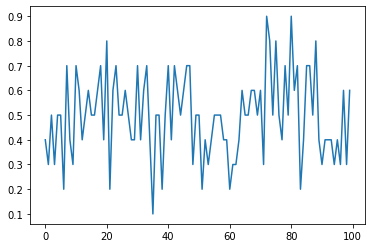

In [78]:
import matplotlib.pyplot as plt

plt.plot(history)

In [79]:
def cost1(params):
    state_squared.trace() + - np.dot(dephaser, circuit(params))